# 1. Image Read

In [3]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

불러온사진 rgb변환

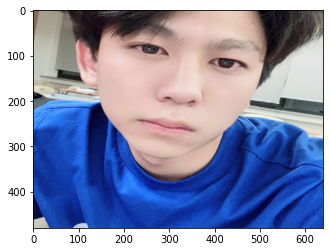

In [4]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 480))    # 640x480의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

# 2. Face Dectection

dlib detector를 이용해서 얼굴의 bounding box 위치 추출

In [5]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print(dlib_rects)   # 찾은 얼굴영역 좌표

rectangles[[(170, 27) (491, 348)]]


bounding box 위치확인

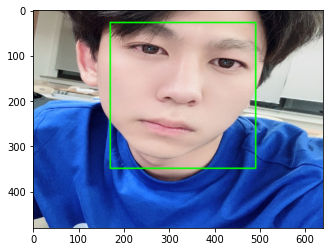

In [6]:
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 3. Face Landmark

land_mark 위치 추출

68


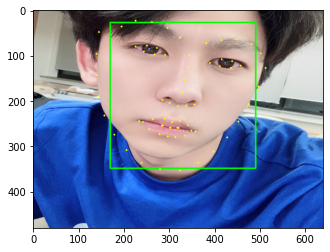

In [7]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 4. Sticker

볼위치 확인

In [8]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[2],landmark[30])  #코와 광대 끝 인덱스
    print (landmark[36],landmark[48]) #눈과 잎술 끝 인덱스  
    #해당 인덱스의 사이의 크기가 볼인 것 을 알수가있다.
    
    x = landmark[30][0] 
    y = landmark[30][1] 
    w = landmark[14][0]-landmark[2][0]  #양쪽 광대쪽 인덱스 거리
    h = landmark[48][1]-landmark[36][1] # 눈과 잎술 사이의 인덱스 거리
    
    print ('(x,y) : (%d,%d)'%(x,y)) # 스티커의 위치 (x,y)
    print ('(w,h) : (%d,%d)'%(w,h)) # 스티커의 크기 (w,h)

(141, 143) (328, 181)
(226, 80) (234, 244)
(x,y) : (328,181)
(w,h) : (335,164)


스티커 이미지 resize 

(164, 335, 3)


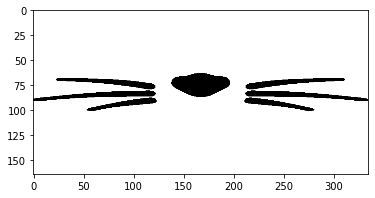

In [9]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)
plt.imshow(img_sticker)
plt.show()

이미지 시작점 위치 변경

In [11]:
refined_x = x - w//2  # left
refined_y = y - h//2  # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (161,99)


# 5. 결과 이미지 출력

In [12]:
#원본이미지 + 스티커적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)

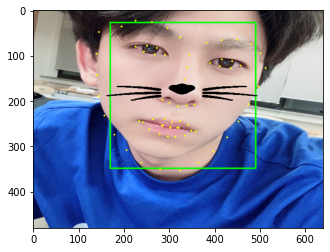

In [13]:
# 결과 이미지 출력
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

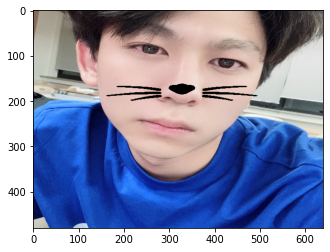

In [14]:
# bounding box와 landmark를 제거하고 최종 결과만 출력
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)

# 결과 이미지 출력
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))  # img_show 대신 아껴 두었던 img_rgb 사용
plt.show()

## 회고

---
인덱스 교점을 이용해서 볼을 찾으려했던 시도

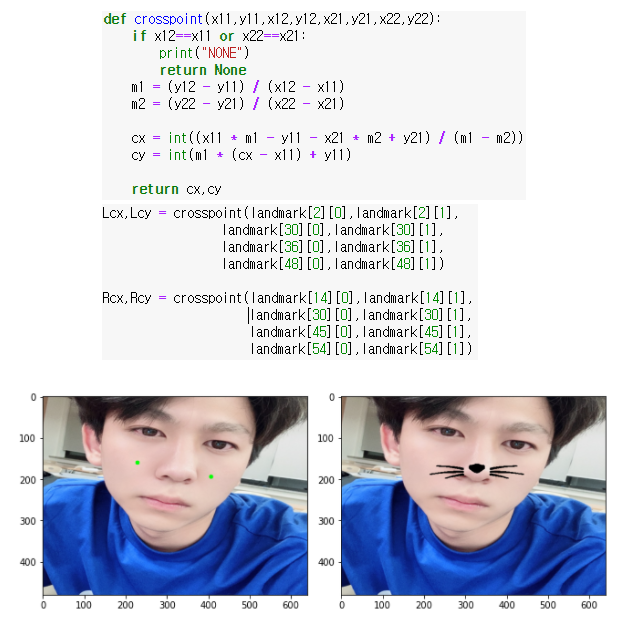

어차피 똑같은 인덱스로 교점을 구한것이기 때문에   
크기만 다를 뿐 다른 사진이 와도 같은 모델로 랜드마크를 추출하여   
큰 영향이 없다.(어떤것이 볼의 영역을 잘 찾았다라는등..)

그렇기에 구지 계산식을 더 추가하면서 교점을 추가하는 방식이 더 복잡해보이기만해서
쓰지 않았다.

## 다양한 이미지

### 1) 멀리서 찍은 사진

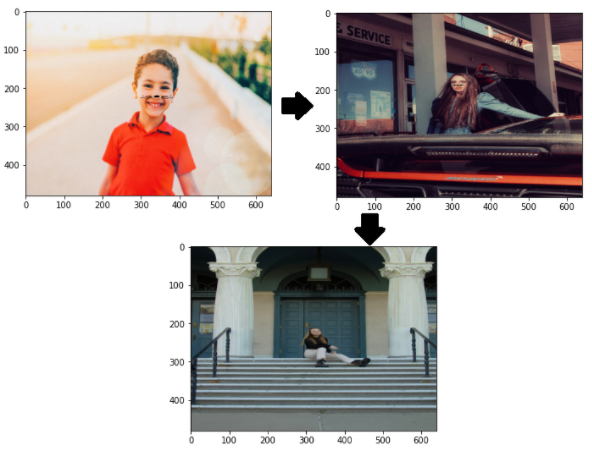

점점 멀어지다 보면 얼굴이 인식이 안되는 순간이 나오면서   
스티커를 적용시킬 수가 없었다.

### 2) 다양한 각도

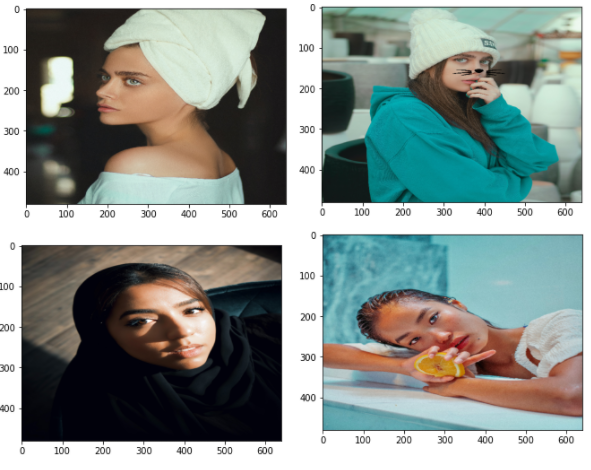

첫번째 사진은 한 쪽볼이 아얘 안나타나서 얼굴을 인식이 안되었고   
세번째와 네번째 사진은 모델에 정해져있는 각도에 적합하지 못해서 얼굴 인식을 못하는것같다.
두번째 사진은 잘 적용이 되었다.

### 3) 어두운 사진

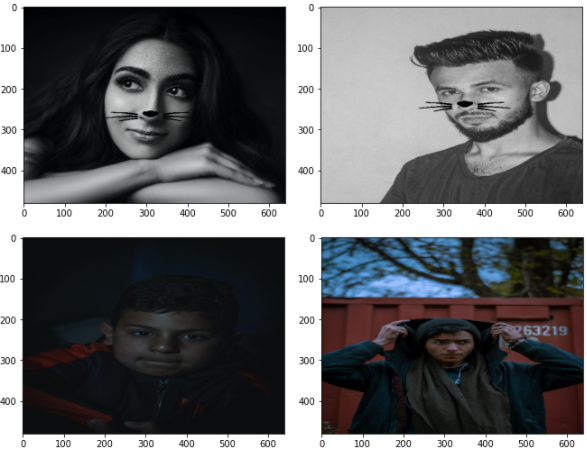

위 두사진은 흑백사진이고 밑 두사진은 어두운 사진이다.   
흑백사진은 문제가 없지만 이미지자체의 밝기가 어두운 사진들은 얼굴을 인식을 잘 못한다.

---
dilb의 face_detector을 사용해서 얼굴을 추출했는데 이 부분을 수정하면 못 찾던 얼굴을 찾을 수 있지 않을까하는 생각이 들었다.